In [115]:
import os
from datetime import datetime
from neon.callbacks.callbacks import Callbacks, GANCostCallback
from neon.callbacks.plotting_callbacks import GANPlotCallback
from neon.initializers import Gaussian
from neon.layers import GeneralizedGANCost, Affine, Sequential, Conv, Deconv, Dropout, Pooling, BatchNorm
from neon.layers.layer import Linear, Reshape
from neon.layers.container import GenerativeAdversarial
from neon.models.model import GAN, Model
from neon.transforms import Rectlin, Logistic, GANCost, Tanh
from neon.util.argparser import NeonArgparser
from neon.util.persist import ensure_dirs_exist
from neon.layers.layer import Dropout
from neon.data.dataiterator import ArrayIterator
from neon.optimizers import GradientDescentMomentum, RMSProp
from gen_data_norm import gen_rhs
from neon.backends import gen_backend

import numpy as np

# load up the data set
train_data, data_y = gen_rhs(100)
eval_data, eval_y = gen_rhs(10)

train_data /= 30.0

gen_backend(backend='cpu', batch_size=10)
train_set = ArrayIterator(X=train_data, y=data_y, nclass=2, lshape=(1, 25, 25, 25))
valid_set = ArrayIterator(X=eval_data, y=eval_y, nclass=2)

# setup weight initialization function
init = Gaussian(scale=0.0001)

# discriminiator using convolution layers
lrelu = Rectlin(slope=0.1)  # leaky relu for discriminator
# sigmoid = Logistic() # sigmoid activation function
conv1 = dict(init=init, batch_norm=False, activation=lrelu) # what's about BatchNorm Layer and batch_norm parameter?
conv2 = dict(init=init, batch_norm=True, activation=lrelu, padding=2)
conv3 = dict(init=init, batch_norm=True, activation=lrelu, padding=1)
D_layers = [Conv((5, 5, 5, 32), **conv1),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv3),
            BatchNorm(),
            Dropout(keep = 0.8),
            Pooling((2, 2, 2)),
            Affine(1, init=init, activation=Logistic())] #what's about the activation function?

# generator using convolution layers
latent_size = 200
relu = Rectlin(slope=0)  # relu for generator
pad1 = dict(pad_h=2, pad_w=2, pad_d=2)
str1 = dict(str_h=2, str_w=2, str_d=2)
conv1 = dict(init=init, batch_norm=True, activation=lrelu, padding=pad1, strides=str1)
pad2 = dict(pad_h=2, pad_w=2, pad_d=2)
str2 = dict(str_h=2, str_w=2, str_d=2)
conv2 = dict(init=init, batch_norm=True, activation=lrelu, padding=pad2, strides=str2)
pad3 = dict(pad_h=0, pad_w=0, pad_d=0)
str3 = dict(str_h=1, str_w=1, str_d=1)
conv3 = dict(init=init, batch_norm=True, activation=Logistic(), padding=pad3, strides=str3)
G_layers = [
            Affine(8 * 7 * 7 * 7, init=init),
            Reshape((8, 7, 7, 7)),
            Deconv((6, 6, 6, 6), **conv1), #14x14x14
            Deconv((5, 5, 5, 64), **conv2), #27x27x27
            Conv((3, 3, 3, 1), **conv3)
           ]
            # what's about the Embedding layer

#G_layers = [Affine(128, init=init, activation=lrelu),
#            Affine(128, init=init, activation=lrelu),
#            Affine(25 * 25 * 25, init=init, activation=Tanh()),
#            Reshape((1, 25, 25, 25))
#            ]

#G_layers = [Affine(25*25*25, init=init, activation=Logistic()), Reshape((1, 25, 25, 25))]
layers = GenerativeAdversarial(generator=Sequential(G_layers, name="Generator"),
                               discriminator=Sequential(D_layers, name="Discriminator"))

# setup optimizer
optimizer = RMSProp(learning_rate=1e-3, decay_rate=0.99, epsilon=1e-8)

# setup cost function as Binary CrossEntropy
cost = GeneralizedGANCost(costfunc=GANCost(func="modified"))

nb_epochs = 3
batch_size = 100
latent_size = 200
nb_classes = 2
nb_test = 100

# initialize model
noise_dim = (100)
gan = GAN(layers=layers, noise_dim=noise_dim)

# configure callbacks
callbacks = Callbacks(gan, eval_set=valid_set)
callbacks.add_callback(GANCostCallback())
callbacks.add_save_best_state_callback("./best_state.pkl")

# run fit
gan.fit(train_set, num_epochs=nb_epochs, optimizer=optimizer,
        cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|   10/10   batches, 1.27 cost, 161.26s]
Epoch 1   [Train |████████████████████|   10/10   batches, 1.52 cost, 177.54s]
Epoch 2   [Train |████████████████████|   10/10   batches, 1.25 cost, 176.85s]


In [118]:
x_new = np.random.rand(10,100)
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(100))

In [119]:
generator = Model(gan.layers.generator)

In [120]:
test = generator.get_outputs(inference_set)

In [121]:
imgs = test.reshape((10, 25, 25, 25))

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

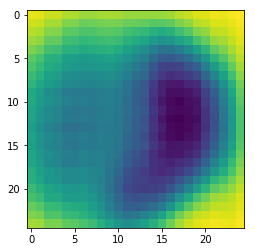

In [123]:
plt.imshow(imgs[0, :, 12, :])

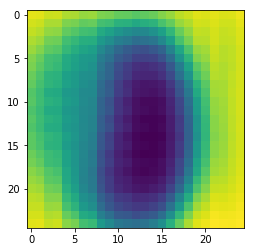

In [126]:
plt.imshow(imgs[1, :, 12, :])

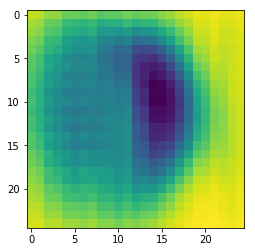

In [129]:
plt.imshow(imgs[9, :, 12, :])